In [2]:
#Importing the libraries 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sympy as sy
import random

#To display the figures in the converted PDF/HTML files
%matplotlib inline

# Question 1

In [3]:
def calError(inliers,circ_x,circ_y,radius):
    sum_ = 0
    for point in inliers:
        sum_ += abs(np.sqrt((point[0]-circ_x)**2+(point[1]-circ_y)**2) - radius)
    return sum_/len(inliers)

def inRange(point,circ_x,circ_y,a,b): 
    return True if a <= np.sqrt((circ_x-point[0])**2 + (circ_y-point[1])**2) <= b else False

def circle(x,y,z):
    x = complex(x[0],x[1])
    y = complex(y[0],y[1])
    z = complex(z[0],z[1])
    try:
        w = z-x
        w /= y-x
        c = (x-y)*(w-abs(w)**2)/2j/w.imag-x
    except ZeroDivisionError:
        return False,False,False
    
    return (-c.real, -c.imag, abs(c+x)) #(-center_x,-center_y,r)

def bestfitCircle(inlier_dots):
    x,y = inlier_dots[:,0],inlier_dots[:,1]
    N = len(x)
    x_bar,y_bar = np.mean(x),np.mean(y)
    u,v = (x - x_bar),(y - y_bar)
    
    a11 = sum(u**2)
    a12 = a21 = sum(u*v)
    a22 = sum(v**2)
    
    b1 = 0.5*(sum(u*(u**2 + v**2)))
    b2 = 0.5*(sum(v*(u**2 + v**2)))
    
    A = np.array([[a11,a12],[a21,a22]])
    B = np.array([[b1],[b2]])
    u_c, v_c = np.linalg.inv(A) @ B
    
    circ_x = u_c + x_bar
    circ_y = v_c + y_bar
    
    radius = np.sqrt(u_c**2 + v_c**2 + (sum(u**2 + v**2))/(N))
    
    return circ_x, circ_y, radius

def circ_RANSAC(X,N):
    
    e = 0.5     # outlier ratio
    s = 3       # Number of point s need to create the estimate model
    p = 0.97    # Probability to choose number of iteration cycles
    thresh = 1.225  # Threshold distance to determine inliers and outliers
    d = 50      # expected number of inliers
    
    iter_rounds = int(np.log(1-p)/np.log(1-(1-e)**s))
    best_samples,best_inliers,best_outliers,best_errors,best_inlier_counts = [],[],[],[],[]
    
    for i in range(iter_rounds):  
        [x,y,z] = random.choices(X,k=3)
        circ_x, circ_y, radius = circle(x,y,z)           
        inliers,outliers = [],[]
        if not (circ_x == False and circ_y == False and radius == False):
            a, b = radius - thresh, radius + thresh
            for point in X:
                point=list(point)
                if inRange(point,circ_x,circ_y,radius - thresh,radius + thresh):  
                    inliers.append(point)
                else:
                    outliers.append(point)        
            if len(inliers) >= d:
                error = calError(inliers,circ_x,circ_y,radius)
                best_errors.append(error), best_samples.append([x,y,z]), best_outliers.append(outliers)    
                best_inliers.append(inliers), best_inlier_counts.append(len(inliers)) 
                
    if len(best_inlier_counts)==0:
        circ_RANSAC(X,N)
    else:   
        best = max(best_inlier_counts)
        best_inlier_counts_np = np.array(best_inlier_counts,dtype=int)
        count = np.count_nonzero(best_inlier_counts_np == best)
        
        if count > 1:
            indexes = np.where(best_inlier_counts_np==best)[0]
            min_i = [indexes[0],best_errors[indexes[0]]]
            for j in range(len(best_errors)):
                if (j in indexes) and (best_errors[j]<min_i[1]):
                    min_i = [j,best_errors[j]]
            k = min_i[0]
        else:
            k = best_inlier_counts.index(best)
           
        best_dots,inlier_dots,outlier_dots  = np.array(best_samples[k]),np.array(best_inliers[k]),np.array(best_outliers[k])
        a,b,c = circle(best_samples[k][0],best_samples[k][1],best_samples[k][2])
        e,f,g = bestfitCircle(inlier_dots)
        
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([i for i in range(-12,13,2)])
        ax.set_yticks([i for i in range(-10,15,2)])
        
        ax.scatter(inlier_dots[:,0],inlier_dots[:,1],color='y',label='Inliers')
        ax.scatter(outlier_dots[:,0],outlier_dots[:,1],color='b',label='Outliers')
        ax.scatter(best_dots[:,0],best_dots[:,1],color='r',label='Best samples')
        
        best_sample_circle = plt.Circle( (a,b ),c ,fill = False,color = 'b',label='Best sample' )
        RANSAC_circle = plt.Circle( (e,f ),g ,fill = False,color='m',label='RANSAC' )
        ax.set_aspect( 1 )
        ax.add_artist( best_sample_circle )
        ax.add_artist( RANSAC_circle )
        
        ax.legend()
        plt.show()


    
    

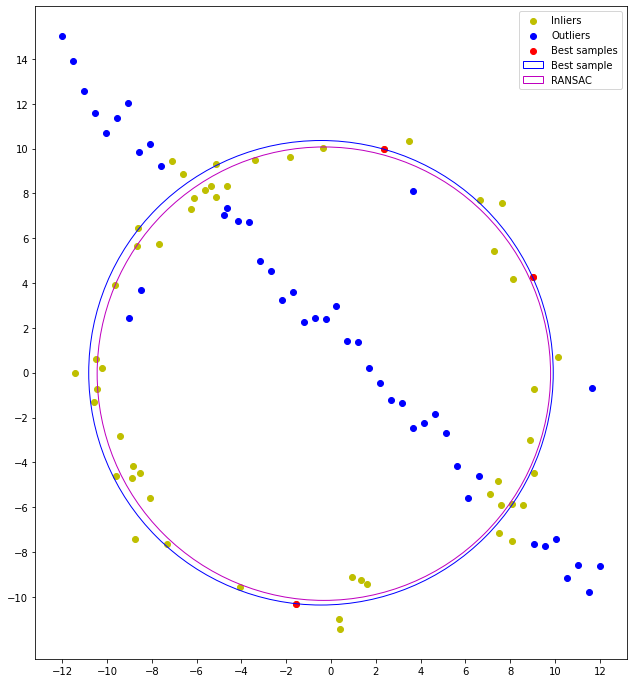

In [6]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0,2*np.pi,half_n )
n = s*np.random.randn(half_n)
x,y = (r + n)*np.cos(t),(r+n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n,1),y.reshape(half_n,1)))
m,b = -1,2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack ( ( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_circ , X_line ) )

circ_RANSAC(X,N)

# Question 2

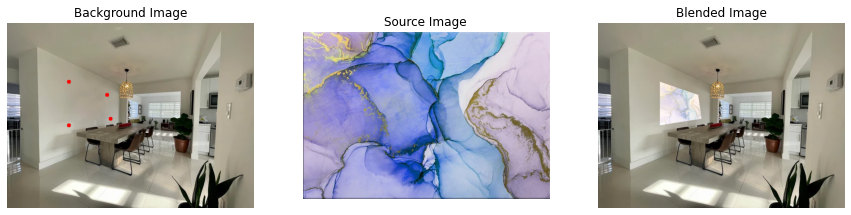

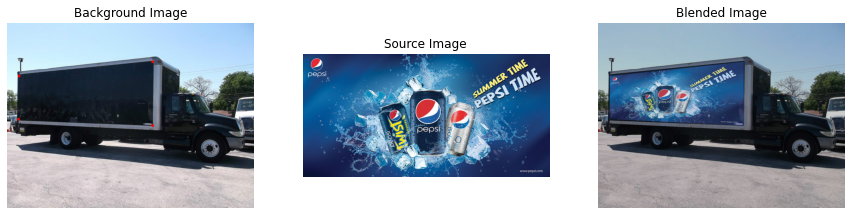

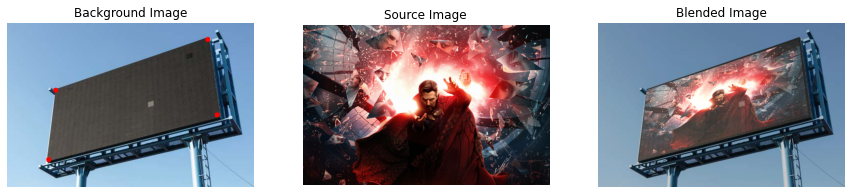

In [5]:
points = []
clicks=0    
def click_event(event, x, y, flags, params):
    global points
    global clicks
    if clicks == 4:
        return
    # checking for left mouse clicks
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x,y])
        clicks+=1
        # displaying the coordinates
        # on the image window
        font = cv.FONT_HERSHEY_SIMPLEX
        cv.circle(img,(x,y),5, (0, 0, 255), -1)
        cv.imshow('image', img)
    
#flag and building 'Images/flag.jpeg','Images/Building/001.jpg',(1,0.6,0.2)
source_images = ['Images/2808-original.jpg','Images/6a831117926931.5c3e10411fa3d.jpg','Images/multiverse-of-madness-trailer.jpg']
backgroung_images = ['Images/m7pyo7l11nl81.webp','Images/img_MpGA6M59zmIVWkQ_r.jpg','Images/billboard.jpg']
coffs = [(1,0.4,0.2),(0.8,0.8,0.2),(0.8,0.8,0.7)]
images = []

for i in range(len(source_images)):
    if len(images)==i+1:pass
    points = []
    clicks = 0
    # reading the image
    img = cv.imread(backgroung_images[i], 1)

    # displaying the image
    cv.imshow('image', img)

    # setting mouse handler for the image
    # and calling the click_event() function
    cv.setMouseCallback('image', click_event)
   
    # wait for a key to be pressed to exit
    cv.waitKey(0)

    # close the window
    cv.destroyAllWindows()

    # Read source image.
    im_src = cv.imread(source_images[i])
    w,h = im_src.shape[1],im_src.shape[0]

    # Four corners of the book in source image
    pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1],[0, h-1]])

    # Read destination image.
    im_dst = cv.imread(backgroung_images[i])

    # Four corners of the book in destination image.
    pts_dst = np.array(points)

    # Calculate Homography
    h, status = cv.findHomography(pts_src, pts_dst)

    # Warp source image to destination based on homography
    im_out = cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
   
    blend = cv.addWeighted(im_dst, coffs[i][0], im_out, coffs[i][1], coffs[i][2])
    images.append([img,im_src,blend]) #background,source,blend
    cv.imshow("Blended Image", blend)
    cv.waitKey(0)

    # close the window
    cv.destroyAllWindows()
    
    
for im in images:
    fig,ax = plt.subplots(1,3,figsize=(15,10))
    titles=['Background Image','Source Image','Blended Image']
    for j in range(3):
        transformed_img_ = cv.cvtColor(im[j],cv.COLOR_BGR2RGB)
        ax[j].axis('off')
        ax[j].imshow(transformed_img_)
        ax[j].set_title(titles[j])

# Question 3

In [7]:
def solve_H(points,des_points):
    A=[]
    for i in range(len(points)):
        A1 = np.concatenate((np.zeros(3),-points[i],des_points[i][1]*points[i]),axis=None)
        A2 = np.concatenate((-points[i],np.zeros(3),des_points[i][0]*points[i]),axis=None)
        A.append(A2)
        A.append(A1)
    A = np.array(A)    
    W,V = np.linalg.eig(A.T @ A)
    # Take the vector corresponds to the minimum eigen value of A.T @ A
    # Sloution H is that vector
    H = np.reshape(np.array(V[:,np.argmin(W)]),(3,3)) 
    return H/H[2][2]

def getMatches(a,b):
    # read images
    img1 = cv.imread('Images/graf/img%d.ppm'%a)  
    img2 = cv.imread('Images/graf/img%d.ppm'%b) 
    
    #sift features
    sift = cv.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    #feature matching
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    fig,ax=plt.subplots(figsize=(10,10))
    ax.axis('off')
    ax.set_title("SIFT Matches")
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
    plt.imshow(img3),plt.show()
    
    # Create FLANN matcher object
    FLANN_INDEX_KDTREE = 0
    indexParams = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
    searchParams = dict(checks=50)
    flann = cv.FlannBasedMatcher(indexParams,searchParams)
    matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)

    # Apply ratio test
    ptsLeft = []
    ptsRight = []
    
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            ptsLeft.append(keypoints_1[m.queryIdx].pt)
            ptsRight.append(keypoints_2[m.trainIdx].pt)

    for i in range(len(ptsLeft)):
        ptsLeft[i]=list(ptsLeft[i])
        ptsLeft[i].append(1)
        ptsRight[i]=list(ptsRight[i])
        ptsRight[i].append(1)
    
    return (np.array(ptsLeft),np.array(ptsRight))

def H_Ransac(points):   
    (ptsLeft,ptsRight) = points
    N = 200
    inlier_counts=[]
    H_set=[]    
    for _ in range(N):
        left_4 = []
        right_4 = []
        inliers=[]
        #pick random 4 points to calculate Homography
        for i in range(4):
            j = np.random.randint(0,len(ptsLeft))
            left_4.append(ptsLeft[j])
            right_4.append(ptsRight[j])
        # Find a temporary homography
        H = solve_H(left_4,right_4) 
        ssd_sum = 0
        # Filter out the inlier points according to the homography
        for j in range(len(ptsLeft)):
            p = ptsLeft[j]
            p_new = (H @ np.reshape(p,(3,1)))
            p_new = p_new/p_new[2:]
            ssd= np.sqrt(np.sum(np.square(np.reshape(p_new,(1,3))-ptsRight[j])))
            if ssd<1:
                inliers.append(p)
        inlier_counts.append(len(inliers))
        H_set.append(H)
    # select the homography with most inliers
    s = H_set[inlier_counts.index(max(inlier_counts))]
    return s/s[2][2]

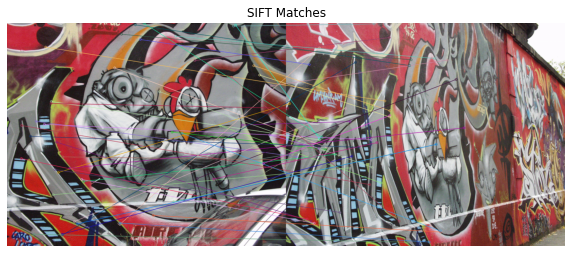

(<matplotlib.image.AxesImage at 0x17d5f96ee90>, None)

In [52]:
    # read images
    img1 = cv.imread('Images/graf/img1.ppm')  
    img2 = cv.imread('Images/graf/img5.ppm') 
    
    #sift features
    sift = cv.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    #feature matching
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    fig,ax=plt.subplots(figsize=(10,10))
    ax.axis('off')
    ax.set_title("SIFT Matches")
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
    plt.imshow(img3),plt.show()

In [39]:

H1 = H_Ransac(getMatches(1,2))
H2 = H_Ransac(getMatches(2,3))
H3 = H_Ransac(getMatches(3,4))
H4 = H_Ransac(getMatches(4,5))    
H_final = H4@H3@H2@H1

print(H_final/H_final[2][2])

[[ 6.30047867e-01  6.01953331e-02  2.21322799e+02]
 [ 2.25760941e-01  1.16859128e+00 -2.59830151e+01]
 [ 4.98866439e-04 -3.19486799e-05  1.00000000e+00]]


In [8]:
H_final = np.array([[ 6.25170214e-01 , 6.30718258e-02,  2.20377906e+02],
 [ 2.19019399e-01 , 1.16637164e+00 ,-2.45215250e+01],
 [ 4.88113336e-04 ,-3.34116504e-05 , 1.00000000e+00]])

Text(0.5, 1.0, 'Image 1 to Image 5')

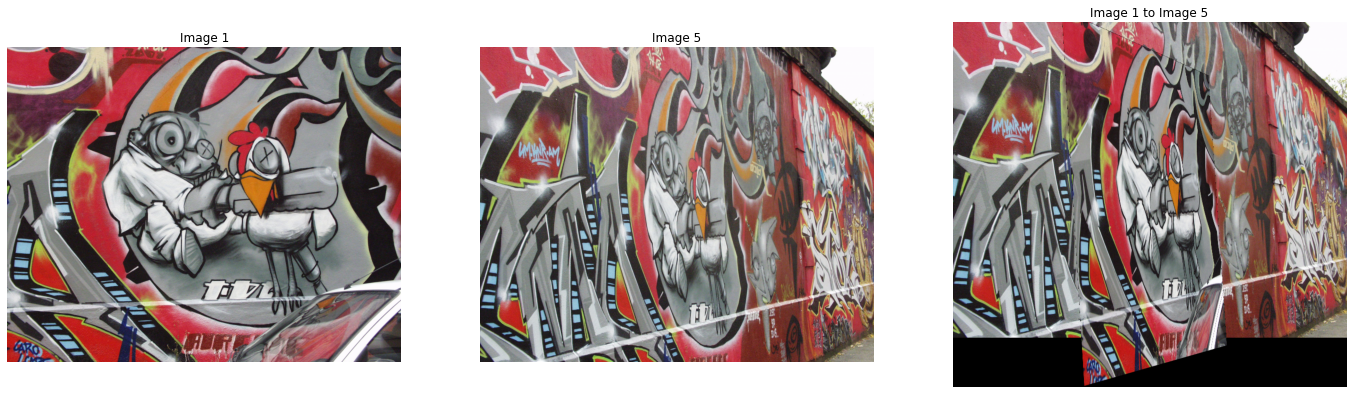

In [9]:
im1 = cv.imread('Images/graf/img1.ppm') 
im5 =  cv.imread('Images/graf/img5.ppm') 
im5_new = cv.warpPerspective(im5,np.identity(3),(im5.shape[1],750))
imnew = cv.warpPerspective(im5,np.linalg.inv(H_final/H_final[2][2]),(3000,800))
imnew2 = cv.warpPerspective(im1,H_final,(im5.shape[1],im5.shape[0]+100))

final = np.copy(imnew2)

for i in range(imnew2.shape[0]):
    for j in range(imnew2.shape[1]):
        if np.all(final[i,j]==0) and i<im5.shape[0] and j<im5.shape[1]:
            final[i][j] = im5[i][j]

f3 = cv.cvtColor(imnew,cv.COLOR_BGR2RGB)
f2 = cv.cvtColor(im5,cv.COLOR_BGR2RGB)
f1 = cv.cvtColor(im1,cv.COLOR_BGR2RGB)
f4 = cv.cvtColor(final,cv.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax[0].imshow(f1)
ax[1].imshow(f2)
ax[2].imshow(f4)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title("Image 1")
ax[1].set_title("Image 5")
ax[2].set_title("Image 1 to Image 5")